<a href="https://www.kaggle.com/code/mmellinger66/titanic-eda01-biased-outliers?scriptVersionId=107294002" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Biased Outliers Titanic EDA

This is a Work in Progress and is a learning exercise for our Machine Learning Study Group.



## Problem Type

Binary Classification

## Evalution Metric

Accuracy

# EDA Outline

- Library Imports
- Configuration
  - class `Config`
  - `TARGET`
  - `TARGET_ENC`
- Theming
- Library - Personal Function Library
- EDA Library - Personal EDA Function Library
- Load Data
   - `train`, `test`, `sample_submission`
- Analyze
    - Train/Test Shape
    - First 5 rows of Train
    - Train Column Names
    - Features/Explanatory Variables
      - Continuous features
      - Categorical features
      - Cardinality of Categorical Features
        - List values for cardinality < 10
        - **TODO**: Identify low cardinality continuous features
        - **TODO**: skew, kurtosis
- Preprocessing
  - Missing Values
  - Percentage of Null Values
  - Describe Data
  - **TODO**:Outlier Detection
- Features
  - Distributions
- Target Variable
  - Distribution
  - Target and Missing Values
- Correlations
  - Correlation Matrix
  - Correlations for Target
- Features Engineering
  - Continuous Features
    - Log of Continuous Features
    - Minimum and Log Minimum of All Continuous Features
    - Maximum and Log Maximum of All Continuous Features
    - Sum and Log Sum of All Continuous Features
    - Multiplication and Log Multiplication of All Continuous Features
    - Prorate of All Continuous Features
    - Log Prorate of All Continuous Features
  - Target Encoding
    - Mean Encoding
    - Minimum Encoding
    - Maximum Encoding
- Baseline
- Other Solutions

# Notebook References

- https://www.datacamp.com/community/tutorials/kaggle-machine-learning-eda
- https://www.kaggle.com/dejavu23/titanic-eda-to-ml-beginner
- https://www.kaggle.com/snikhil17/making-basic-eda-attractive
- https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
- https://www.kaggle.com/desalegngeb/march-tps-eda-visualizations
- https://www.kaggle.com/dwin183287/tps-september-2021-eda

# Programming References

## Seaborn

- https://www.geeksforgeeks.org/seaborn-color-palette/
- https://www.codecademy.com/articles/seaborn-design-ii
- https://chrisalbon.com/code/python/data_visualization/seaborn_color_palettes/

The data:
   - 8 categorical variables: **Cabin, Embarked, Name, Parch Pclass, Sex, SibSp, Ticket**
   - 2 continuous variables: **Age, Fare**
   - 1 binary target column: **Survived**

# Import Libraries

In [1]:
from pathlib import Path

import numpy as np 
import pandas as pd

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno


import warnings # Enable warnings for cleaner code
#warnings.filterwarnings('ignore')
%matplotlib inline


## Configuration

In [2]:
class Config:
    path = "../input/titanic/"

In [3]:
TARGET = "Survived"
TARGET_ENC = ""

## Theming

Make the EDA configurable so we can reuse with a different style.

## Generate Color Palette

- https://coolors.co
- https://color.adobe.com/create/color-wheel

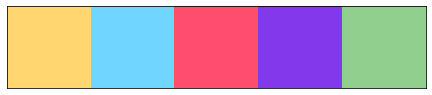

In [4]:
mpl.rcParams['font.size'] = 16

theme_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(theme_colors))

sns.palplot(sns.color_palette(theme_colors),size=1.5)
plt.tick_params(axis='both', labelsize=0, length = 0)

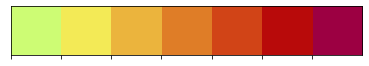

In [5]:
my_colors = ["#CDFC74", "#F3EA56", "#EBB43D", "#DF7D27", "#D14417", "#B80A0A", "#9C0042"]
sns.palplot(sns.color_palette(my_colors), size=0.9)

In [6]:
from itertools import cycle

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

plt.style.use('ggplot') # 'fivethirtyeight'

# plt.style.available

plt.rcParams["figure.figsize"] = (12, 8) # Default figure size

## Library

Create a library of reusable functions.

In [7]:
def read_data(path, show_info=True):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "gender_submission.csv")

    if show_info:
        print("=== Shape of Data ===")
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print("\n=== Train Data: First 5 Rows ===\n")
        display(train.head())
        print("\n=== Train Column Names ===\n")
        display(train.columns)
        print("\n=== Features/Explanatory Variables ===\n")
        eval_features(train)
    return train, test, submission_df



## EDA Library

Functions specific to an EDA kernel

- show_duplicate_records(df)
- show_missing_features(df)

In [8]:

def show_missing_features(df):
    missing_vals = df.isna().sum().sort_values(ascending=False)
    print(missing_vals[missing_vals > 0])
    
def show_duplicate_records(df):
    dups = df.duplicated()
    print(dups.sum())    
    
def eval_features(df):
    ## Separate Categorical and Numerical Features
    categorical_features = list(df.select_dtypes(include=["category", "object"]).columns)
    continuous_features = list(df.select_dtypes(include=["number"]).columns)

    print(f"Continuous features: {continuous_features}")
    print(f"Categorical features: {categorical_features}")
    print("\n --- Cardinality of Categorical Features ---\n")

    for feature in categorical_features:
        cardinality=df[feature].nunique()
        if cardinality < 10:
            print(f"{feature}: cardinality={cardinality}, {df[feature].unique()}")
        else:
            print(f"{feature}: cardinality={cardinality}")
    all_features = categorical_features + continuous_features
    return all_features, categorical_features, continuous_features

def show_feature_importance(feature_importance_lst):
    fis_df = pd.concat(feature_importance_lst, axis=1)

    fis_df.sort_values("0_importance", ascending=True).head(40).plot(
        kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
    )
    plt.show()
    
def show_feature_target_crosstab(df, feature_lst, target):
    for feature in feature_lst:
        print(f"\n=== {feature} vs {target} ===\n")
        display(pd.crosstab(df[feature], df[target], margins=True)) # display keeps bold formatting
        
def show_cardinality(df, features):
    print("=== Cardinality ===")
    print(df[features].nunique())

def show_unique_features(df, features):
    for col in features:
        print (col, sorted(df[col].dropna().unique()))
    
def feature_distribution_types(df, display=True):
    continuous_features = df.select_dtypes(include=['int64', 'float64', 'uint8']).columns
    categorical_features = df.select_dtypes(include=['object', 'bool']).columns
    if display:
        print(f"Continuous Features={continuous_features}\n")
        print(f"Categorical Features={categorical_features}")
    return continuous_features, categorical_features        
        

# Load Data and Analyze

### Analyze
- Train/Test Shape
- First 5 rows of Train
- Train Column Names
- Features/Explanatory Variables
  - Continuous features
  - Categorical features
  - Cardinality of Categorical Features
    - List values for cardinality < 10

In [9]:
train, test, sample_submission = read_data(Config.path)

=== Shape of Data ===
 train data: Rows=891, Columns=12
 test data : Rows=418, Columns=11

=== Train Data: First 5 Rows ===



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



=== Train Column Names ===



Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


=== Features/Explanatory Variables ===

Continuous features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

 --- Cardinality of Categorical Features ---

Name: cardinality=891
Sex: cardinality=2, ['male' 'female']
Ticket: cardinality=681
Cabin: cardinality=147
Embarked: cardinality=3, ['S' 'C' 'Q' nan]


In [10]:
continuous_features, categorical_features = feature_distribution_types(test)
# type(continuous_features.values())
# continuous_features.remove("Survived")

Continuous Features=Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

Categorical Features=Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


## Continuous Distributions

Feature: PassengerId
Feature: Pclass
Feature: Age
Feature: SibSp
Feature: Parch
Feature: Fare


<Figure size 864x576 with 0 Axes>

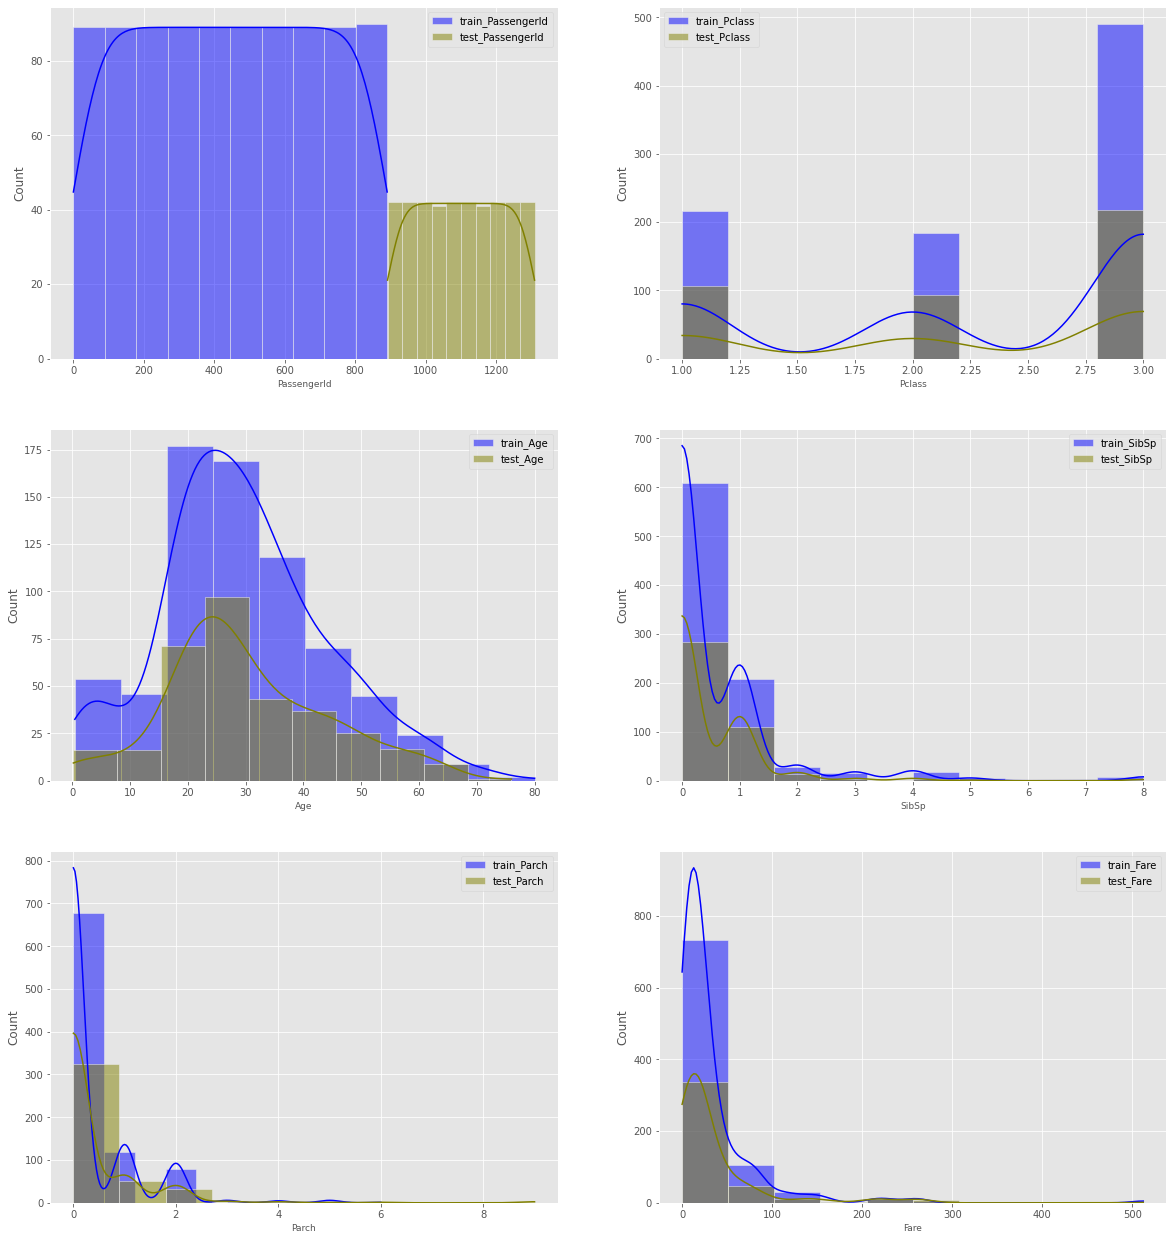

In [11]:
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(20, 22))

for i, feature in enumerate(continuous_features):
    print(f"Feature: {feature}")
    plt.subplot(3, 2, i + 1)
    sns.histplot(
        x=feature, color="blue", kde=True, bins=10, label="train_" + feature, data=train
    )
    sns.histplot(
        x=feature, color="olive", kde=True, bins=10, label="test_" + feature, data=test
    )
    plt.xlabel(feature, fontsize=9)
    plt.legend()
plt.show()

## Categorical Distributions

Feature: Embarked
Feature: Sex


<Figure size 864x576 with 0 Axes>

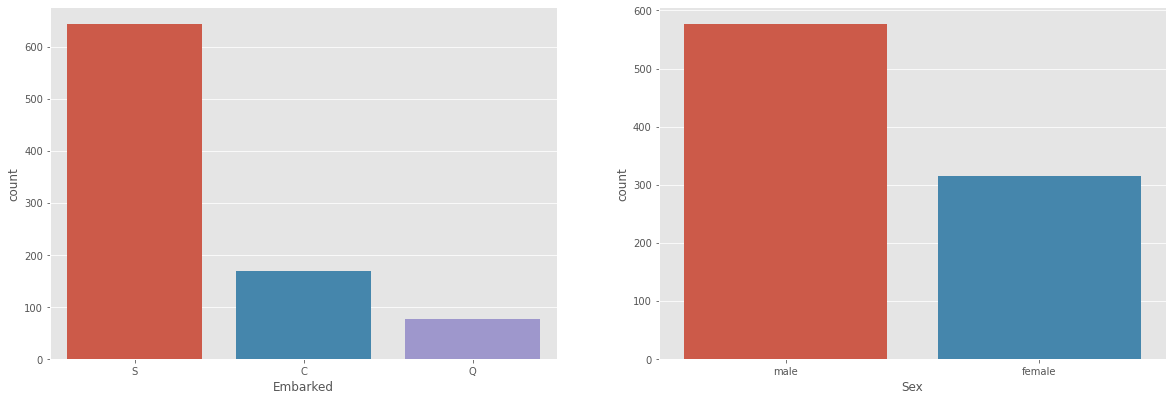

In [12]:
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(20, 22))

categorical_features = ["Embarked", "Sex"]
for i, feature in enumerate(categorical_features):
    print(f"Feature: {feature}")
    plt.subplot(3, 2, i + 1)
    sns.countplot(
        x=feature, label="train_" + feature, data=train
    )
#     sns.histplot(
#         test[feature], color="olive", kde=True, bins=10, label="test_" + feature
#     )
#     plt.xlabel(feature, fontsize=9)
#     plt.legend()
plt.show()

# Preprocessing

## Missing Data

<AxesSubplot:>

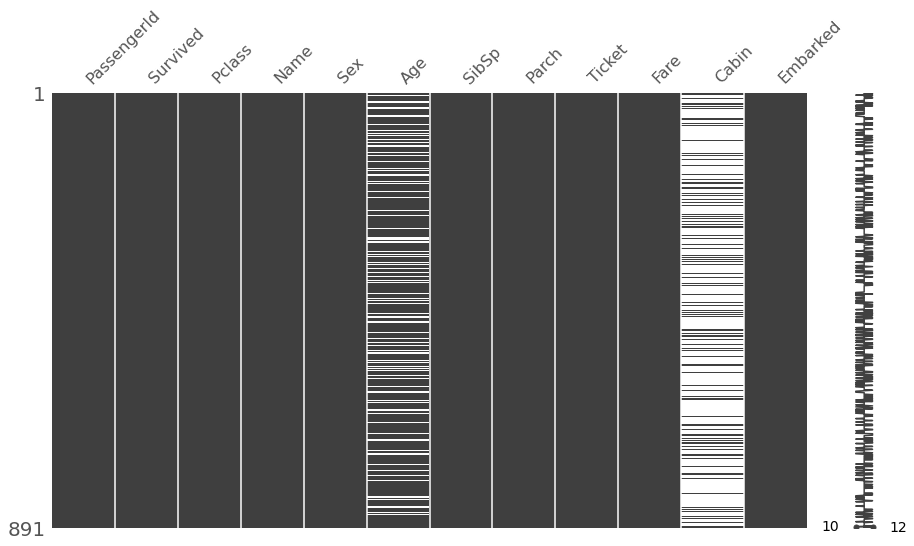

In [13]:
msno.matrix(train, figsize=(15, 8))

<AxesSubplot:>

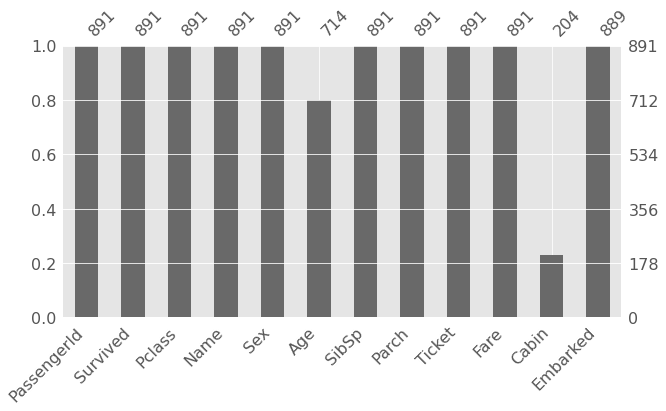

In [14]:
msno.bar(train,figsize=(10, 5))

# Percentage of Null Values

In [15]:
show_missing_features(train)

Cabin       687
Age         177
Embarked      2
dtype: int64


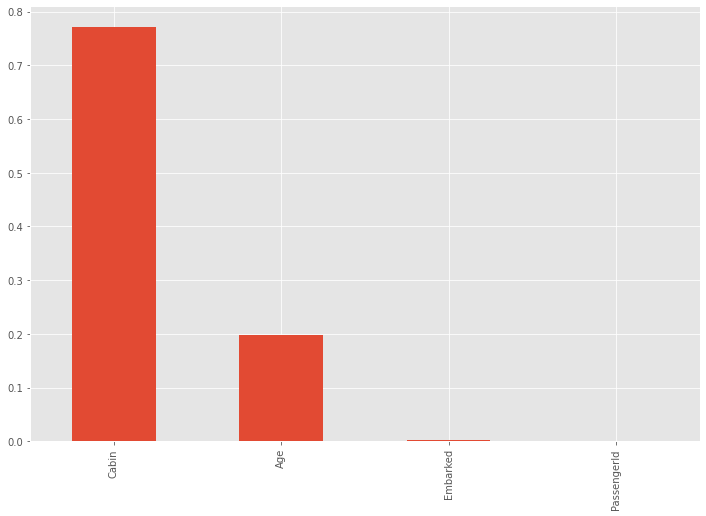

In [16]:
(train.isnull().sum()/train.shape[0]).sort_values(ascending = False).head(4).plot(kind='bar');

# Figure out a better way to exclude zero rows

In [17]:
train.isnull().sum().sort_values(ascending = False).to_frame().head(70).rename({0:'Counts'}, axis = 1).T.style.background_gradient('crest')

,Cabin,Age,Embarked,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
Counts,687,177,2,0,0,0,0,0,0,0,0,0


In [18]:
#printing only 70 columns with highest percentage of Null values
display(round((train.isnull().sum() / (len(train.index)) * 100) , 2).sort_values(ascending = False).head(70).to_frame().rename({0:'%age'}, axis = 1).T.style.background_gradient('magma_r'))
print()
missing = (train.isnull().sum() / (len(train.index)) * 100).to_frame().reset_index().rename({0:'%age'}, axis = 1)



,Cabin,Age,Embarked,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
%age,77.100000,19.870000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


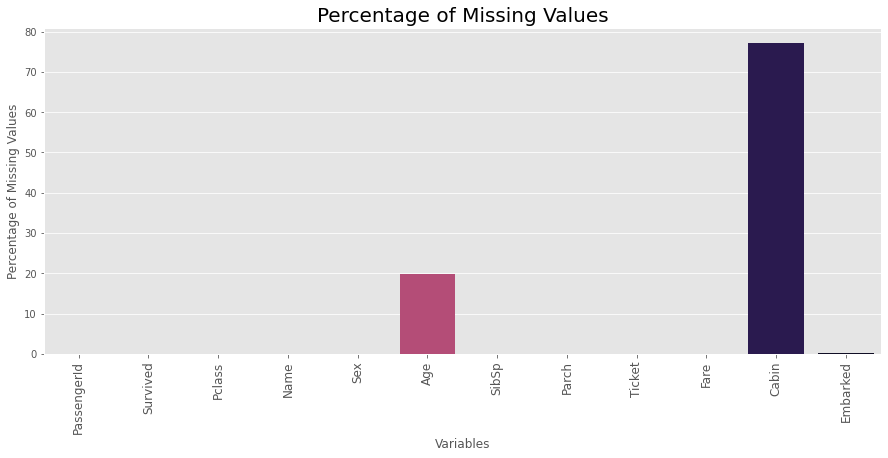

In [19]:
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=missing['index'], y=missing['%age'], palette  = 'magma_r')
plt.title("Percentage of Missing Values", fontsize = 20)
plt.xticks(fontsize=12, rotation = 90)
plt.xlabel("Variables")
plt.ylabel("Percentage of Missing Values")
plt.show();

# Describe Data

- count
- mean
- standard deviation
- minimum
- 1st quartile
- median
- 3rd quartile
- maximum

cmap: 'autumn', 'autumn_r', 'coolwarm'

In [20]:
X = train.drop(["PassengerId"], axis=1) # Remove row id
X.describe().transpose().style.background_gradient(cmap='coolwarm').set_precision(4)

,count,mean,std,min,25%,50%,75%,max
Survived,891.0000,0.3838,0.4866,0.0000,0.0000,0.0000,1.0000,1.0000
Pclass,891.0000,2.3086,0.8361,1.0000,2.0000,3.0000,3.0000,3.0000
Age,714.0000,29.6991,14.5265,0.4200,20.1250,28.0000,38.0000,80.0000
SibSp,891.0000,0.5230,1.1027,0.0000,0.0000,0.0000,1.0000,8.0000
Parch,891.0000,0.3816,0.8061,0.0000,0.0000,0.0000,0.0000,6.0000
Fare,891.0000,32.2042,49.6934,0.0000,7.9104,14.4542,31.0000,512.3292


# Separate target from features


In [21]:
# y = train[TARGET]
# features = train.drop([TARGET], axis=1)
# # test.drop(['id'], axis = 1, inplace = True)

# # Preview features
# features.head()


# Target Variable

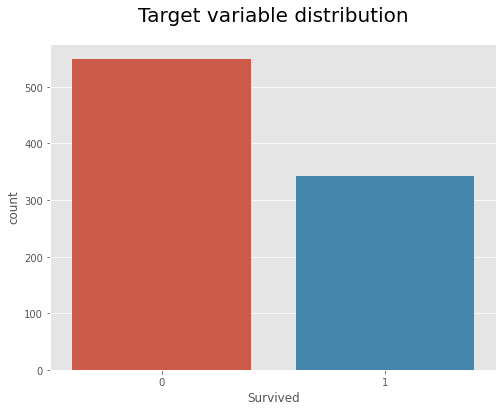

In [22]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=TARGET, data=train);
ax.set_title('Target variable distribution', fontsize=20, y=1.05);
# sns.despine(right=True)
# sns.despine(offset=10, trim=True)

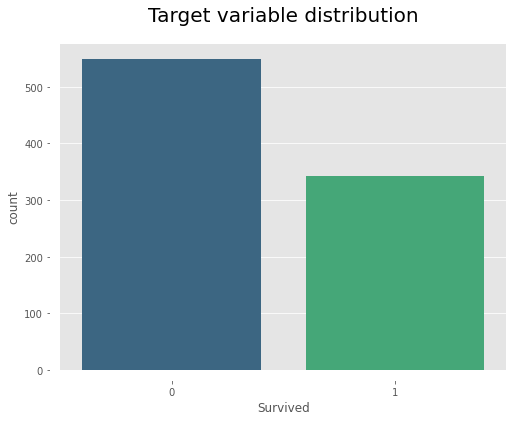

In [23]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=train[TARGET], palette='viridis')
ax.set_title('Target variable distribution', fontsize=20, y=1.05)

sns.despine(right=True)
sns.despine(offset=10, trim=True)

# Calculate Target Ratio

For binary class, we don't want it to be out of balance

In [24]:
percent_survived = train.Survived.sum()/train.Survived.count()
print(f"Class: 0 = {1 - percent_survived:.2f} 1 = {percent_survived:.2f}")

Class: 0 = 0.62 1 = 0.38


# Features

- Separate numerical and categorical features.
- Determine cardinality of categorical and numerical features
  - Low cardinality of numerical features means they could be categorical

### Cardinality of Features

In [25]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [26]:
cont_cols = ['Age', 'Fare']

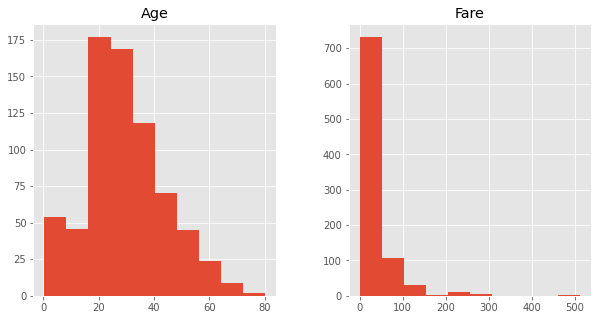

In [27]:
train[cont_cols].hist(figsize=(10,5))
plt.show()

In [28]:
cont_feats, cat_feats = feature_distribution_types(train, display=True)
show_cardinality(train, cat_feats)
show_unique_features(train, ["Embarked", "Pclass"])

Continuous Features=Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

Categorical Features=Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')
=== Cardinality ===
Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64
Embarked ['C', 'Q', 'S']
Pclass [1, 2, 3]


# Numerical Features

# Categorical Features

In [29]:
# cat_cols = ['Cabin', 'Embarked', 'Name', 'Parch' 'Pclass', 'Sex', 'SibSp', 'Ticket']
cat_cols = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

- https://www.kaggle.com/subinium/tabularplayground-feb-eda-visualization

In [30]:
for col in cat_cols:
#     print (col)
#     print(train[col].dropna())
    print (col, sorted(train[col].dropna().unique()))

Embarked ['C', 'Q', 'S']
Parch [0, 1, 2, 3, 4, 5, 6]
Pclass [1, 2, 3]
Sex ['female', 'male']
SibSp [0, 1, 2, 3, 4, 5, 8]


# Feature: Sex vs TARGET

### Crosstab

In [31]:
pd.crosstab(train["Sex"], train[TARGET], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


In [32]:
show_feature_target_crosstab(train, ["Sex", "Embarked", "Pclass"], TARGET)


=== Sex vs Survived ===



Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891



=== Embarked vs Survived ===



Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889



=== Pclass vs Survived ===



Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


### Groupby

In [33]:
feature = "Sex"
train.groupby([TARGET,feature])[TARGET].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Survived, dtype: int64

In [34]:
survive_percent_male = train[train.Sex == "male"].Survived.sum() / train[train.Sex == "male"].Survived.count()
survive_percent_female = train[train.Sex == "female"].Survived.sum() / train[train.Sex == "female"].Survived.count()

print(f"Male Survivors  : {survive_percent_male:.3}")
print(f"Female Survivors: {survive_percent_female:.3}")

Male Survivors  : 0.189
Female Survivors: 0.742


# catplot: Point, Count, Violin, Swarm

- https://seaborn.pydata.org/generated/seaborn.catplot.html

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 95.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 82.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 61.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


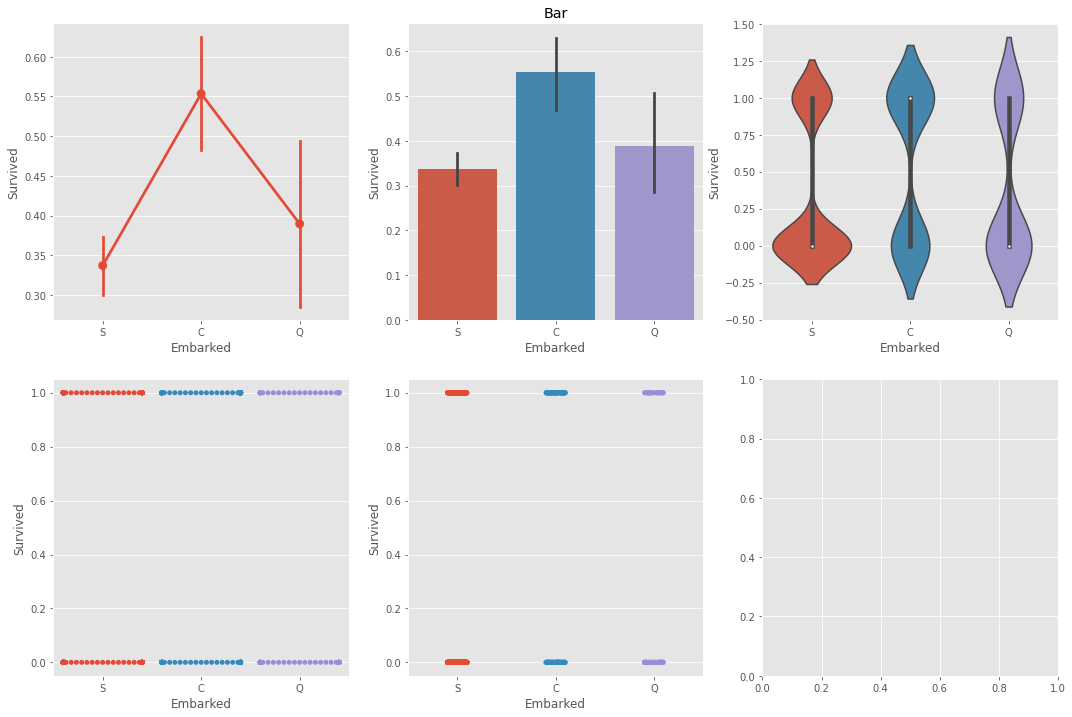

In [35]:
f,ax = plt.subplots(2,3,figsize=(18,12))

# ax[0,0].set_title('Foo')
sns.pointplot(x='Embarked',y='Survived', data=train, ax=ax[0][0])
sns.barplot(x='Embarked',y='Survived', data=train, ax=ax[0][1])
sns.violinplot(x='Embarked',y='Survived', data=train, ax=ax[0][2])
sns.swarmplot(x='Embarked',y='Survived', data=train, ax=ax[1][0])
sns.stripplot(x='Embarked',y='Survived', data=train, ax=ax[1][1])

# sns.catplot(x='Embarked',y='Survived', kind='point', data=train);
# sns.catplot(x='Embarked', kind='count', data=train, ax=ax[1]);

# sns.catplot(x='Embarked',y='Survived', kind='point', data=train);
# sns.catplot(x='Embarked', kind='count', data=train);

ax[0,1].set_title('Bar')
# plt.grid()  #just add this

plt.show()


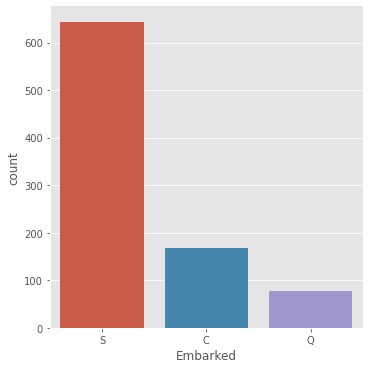

In [36]:
sns.catplot(x='Embarked', kind='count', data=train);


In [37]:
train.groupby([TARGET,'Pclass','Sex'])[TARGET].count()

Survived  Pclass  Sex   
0         1       female      3
                  male       77
          2       female      6
                  male       91
          3       female     72
                  male      300
1         1       female     91
                  male       45
          2       female     70
                  male       17
          3       female     72
                  male       47
Name: Survived, dtype: int64

In [38]:
train.groupby([TARGET,'Sex','Pclass'])[TARGET].count()

Survived  Sex     Pclass
0         female  1           3
                  2           6
                  3          72
          male    1          77
                  2          91
                  3         300
1         female  1          91
                  2          70
                  3          72
          male    1          45
                  2          17
                  3          47
Name: Survived, dtype: int64

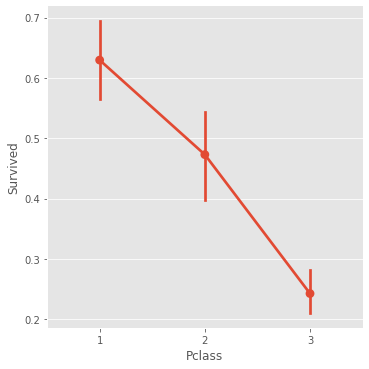

In [39]:
sns.catplot(x='Pclass',y=TARGET, kind='point', data=train);

In [40]:
pd.crosstab([train.Sex, train[TARGET]], train.Pclass, margins=True).style.background_gradient(cmap='autumn_r')

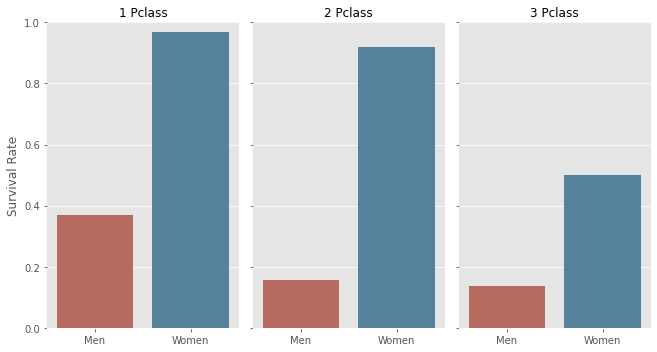

In [41]:
# https://seaborn.pydata.org/generated/seaborn.catplot.html - Bottom of page
# FacetGrid

g = sns.catplot(x="Sex", y=TARGET, col="Pclass",
                data=train, saturation=.5,
                kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Survival Rate")
  .set_xticklabels(["Men", "Women"]) # , "Children"
  .set_titles("{col_name} {col_var}")
  .set(ylim=(0, 1))
  .despine(left=True));  

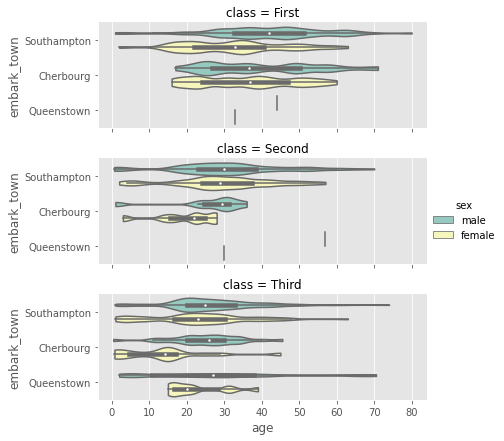

In [42]:
titanic = sns.load_dataset("titanic")

g = sns.catplot(x="age", y="embark_town",
                hue="sex", row="class",
                data=titanic[titanic.embark_town.notnull()],
                orient="h", height=2, aspect=3, palette="Set3",
                kind="violin", dodge=True, cut=0, bw=.2)


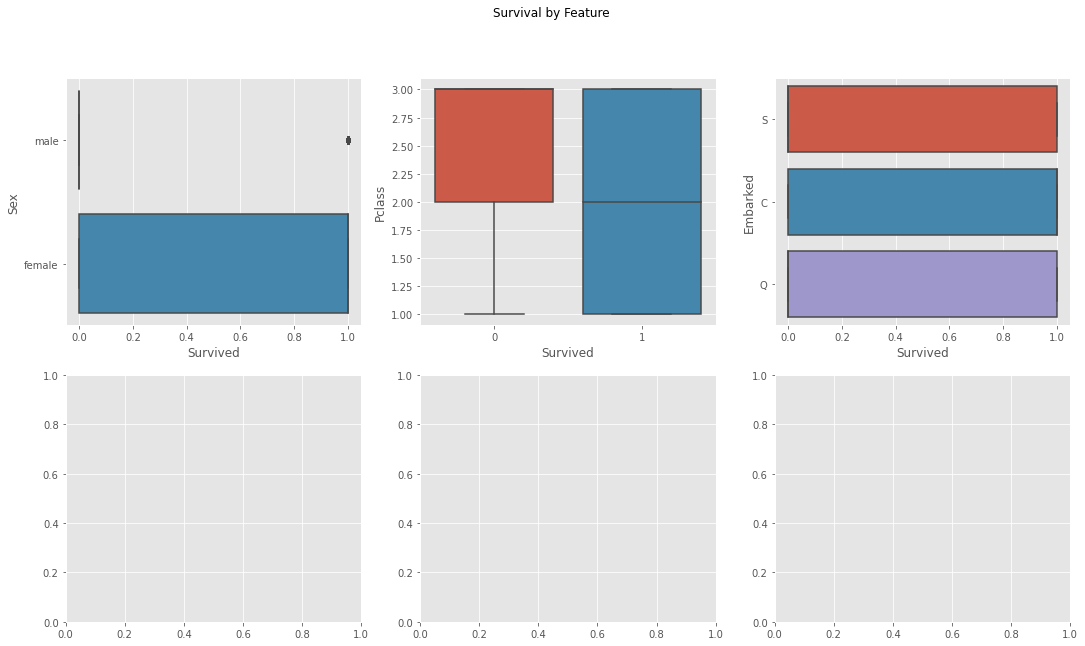

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Survival by Feature')

sns.boxplot(ax=ax[0, 0], data=train, x=TARGET, y='Sex');
sns.boxplot(ax=ax[0, 1], data=train, x=TARGET, y='Pclass');
sns.boxplot(ax=ax[0, 2], data=train, x=TARGET, y='Embarked');


# Correlation Matrix

### Fill in missing values first?

In [44]:
X = train.copy()
X = X.drop(['PassengerId'], axis=1)
corr = X.corr()
corr

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


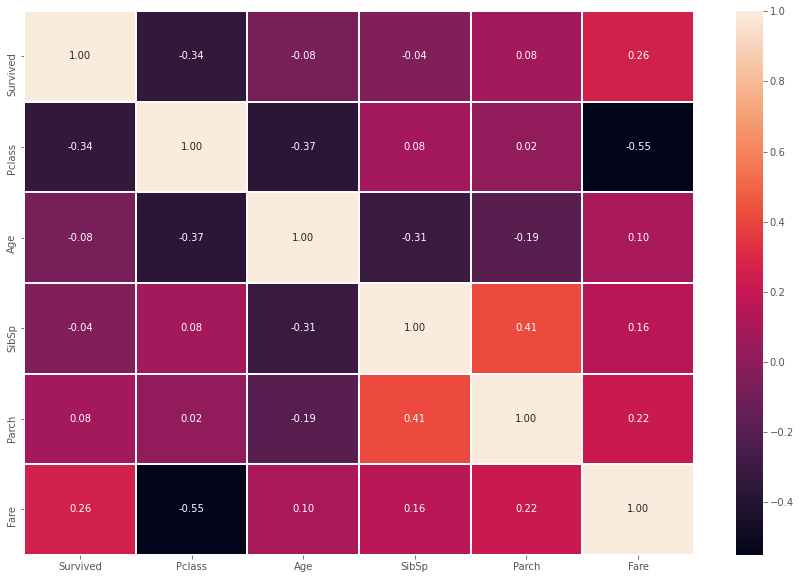

In [45]:
f,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

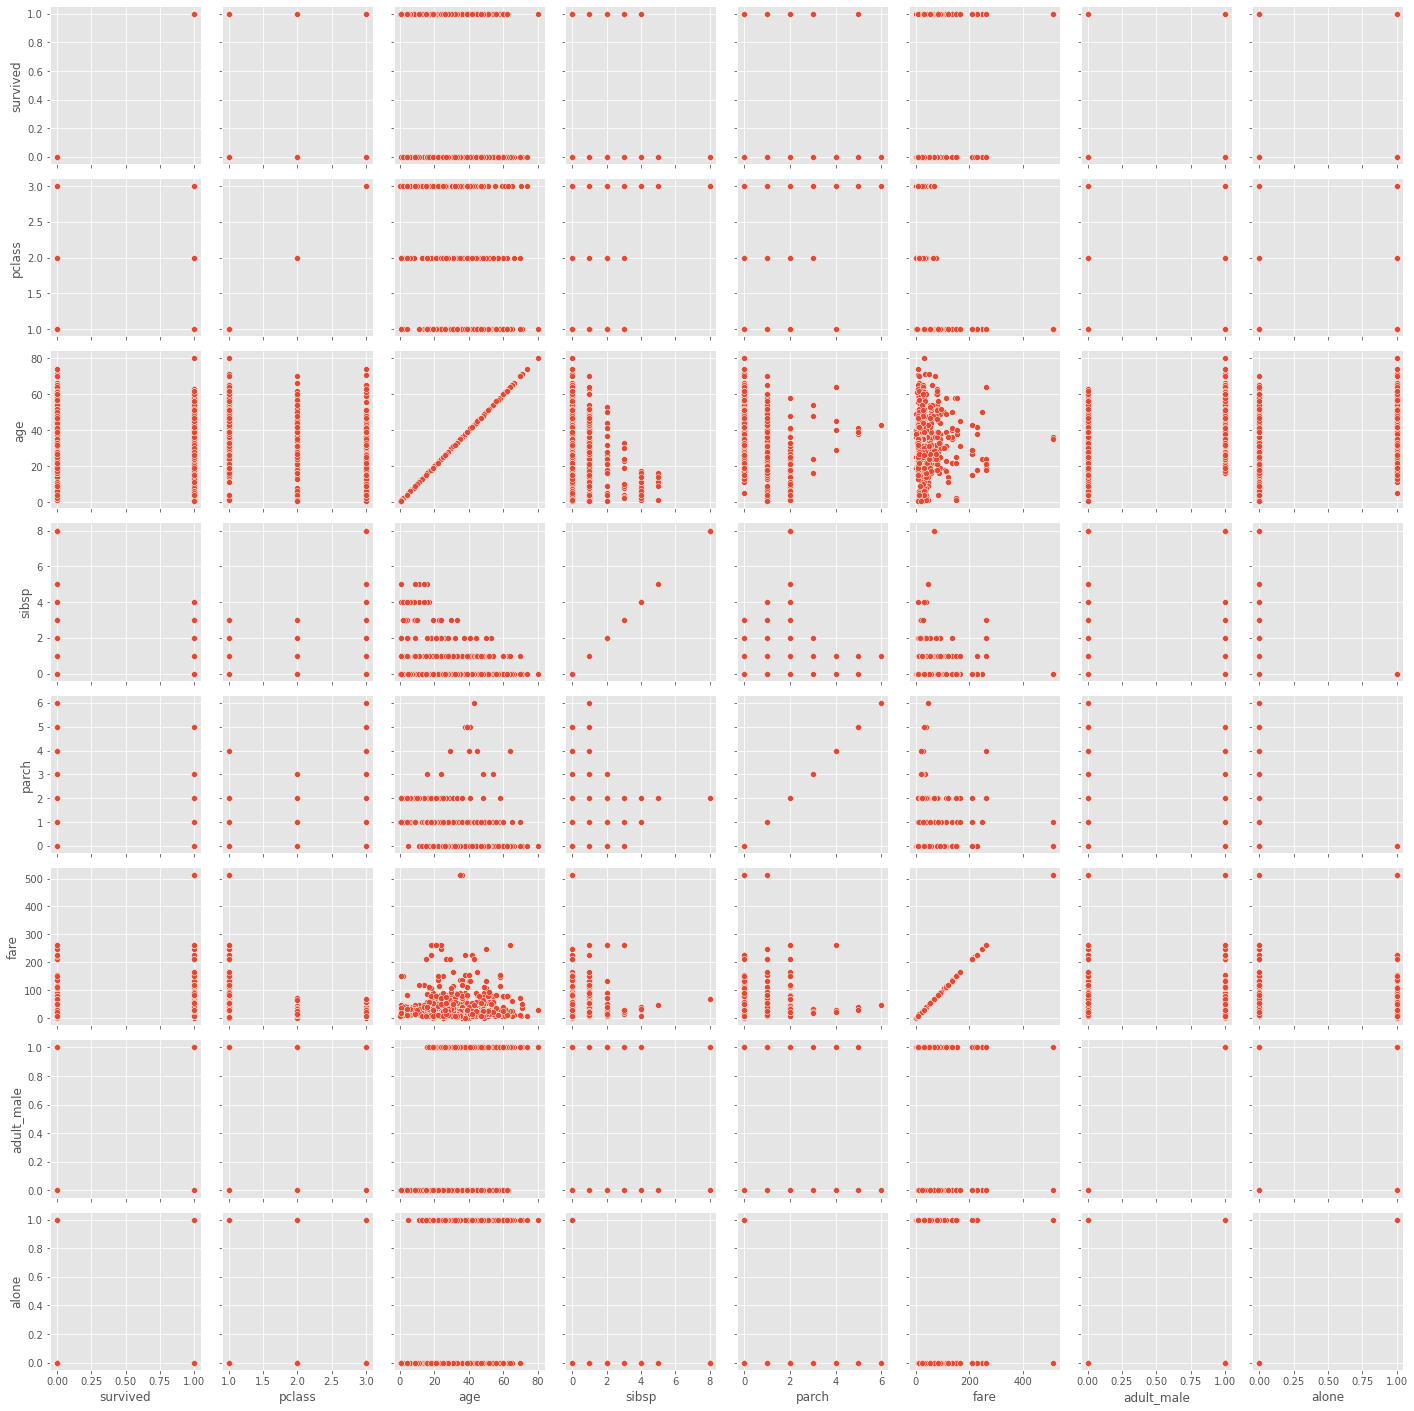

In [46]:
# https://seaborn.pydata.org/tutorial/axis_grids.html

titanic = sns.load_dataset("titanic")
g = sns.PairGrid(titanic)
g.map(sns.scatterplot);


In [47]:

corr_matrix = train.corr()[[TARGET]].sort_values(by = [TARGET], ascending = False).drop([TARGET]).T
corr_matrix.style.set_precision(4)
# corr_matrix.style.background_gradient(cmap = 'coolwarm').set_precision(4)


,Fare,Parch,PassengerId,SibSp,Age,Pclass
Survived,0.2573,0.0816,-0.0050,-0.0353,-0.0772,-0.3385
